In [1]:
from google.colab import drive
!mkdir drive
drive.mount('/content/drive/')

!pip3 install torch torchvision
!pip3 install --no-cache-dir -I pillow



import os
os.chdir("drive/My Drive")
!ls

mkdir: cannot create directory ‘drive’: File exists
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
    100% |████████████████████████████████| 2.0MB 50.8MB/s 
  [PIL]
You must restart the runtime in order to use newly installed versions.
 323_082014.pdf			      Loki.mp4
 alexnet_model.pth		      mail_me.py
 alexnet_model.pth_loss		      mail_me.pyc
 assets				     'Manutenção carros.gsheet'
 Blogs				     'Masters IA.gdoc'
 BMF.gsheet			      ML_Class
 Business			      model.pth
 Caelum				     'new doc 19.pdf'
 cat_to_name.json		     'Ninja Peças.gsheet'
'Colab Notebooks'		     'Object Tracking.html'
 Coursera			      Photos
 data_load.py			     'Planilha sem título (1).gsheet'
'Desenho sem título (1).gdraw'	     'Planilha sem título (2).gsheet'
'Desenho sem título.gdraw'	     'Planilha sem título.gsheet'
'Documento sem título.gdoc'	      Pong_Location_Speed_States.html
 drive				      Project

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# Imports here
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models


from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

import PIL
import numpy as np
import json

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'



In [0]:
# TODO: Define your transforms for the training and validation sets
data_transforms = transforms.Compose([
                                      transforms.Resize(330),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])


valid_transforms = transforms.Compose([ transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])
# TODO: Load the datasets with ImageFolder
train_dataset = ImageFolder(train_dir,data_transforms)
valid_dataset = ImageFolder(valid_dir,valid_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
# define dataloader parameters
batch_size = 32
num_workers=0
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:


with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
#print(cat_to_name)

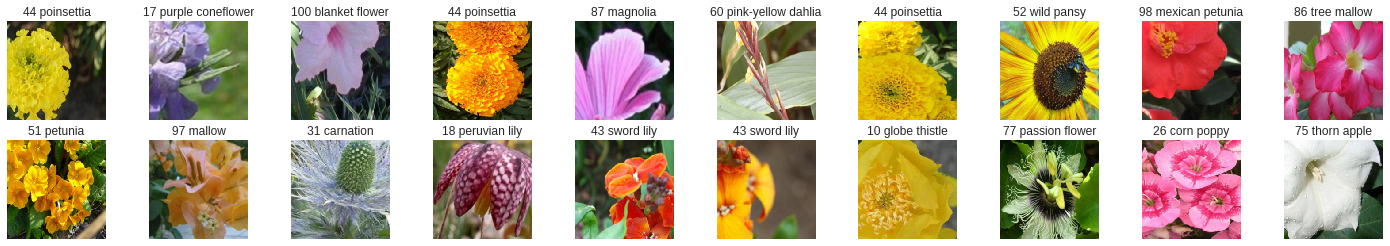

In [7]:
# Visualize some sample data


# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.clip(std * np.transpose(images[idx], (1, 2, 0)) + mean,0,1))
    #print(labels[idx].numpy())
    ax.set_title(str(labels[idx].numpy()) + ' ' +cat_to_name[str(labels[idx].numpy())])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [8]:
model_used = 1 #selects 1 for VGG19, #2 for Resnet50, 3 for Alexnet

model = None
if model_used == 1:
    model = models.vgg19(pretrained=True)
    model_path = 'vgg_model.pth'
elif model_used == 2:
    model =  models.resnet50(pretrained=True)
    model_path = 'resnet_model.pth'
elif model_used == 3:
    model = models.alexnet(pretrained=True)
    model_path = 'alexnet_model.pth'
        
print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:12<00:00, 46307527.42it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
# TODO: Build and train your network

if model_used == 2:
    
    for param in model.parameters():
        param.requires_grad = False
        
    n_inputs = model.fc.in_features
    
    # add last linear layer (n_inputs -> cat_to_name)
    # new layers automatically have requires_grad = True
    model.fc = nn.Linear(n_inputs, len(cat_to_name))
    
else:

    # Freeze training for all "features" layers
    for param in model.features.parameters():
        param.requires_grad = False

    n_inputs = model.classifier[-1].in_features

    # add last linear layer (n_inputs -> cat_to_name)
    # new layers automatically have requires_grad = True
    last_layer = nn.Linear(n_inputs, len(cat_to_name))
    model.classifier[-1] = last_layer


# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

# check to see that your last layer produces the expected number of outputs
#print(model.classifier[-1].out_features)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

loss_hist = []


# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [0]:
def load_model(model_path):
    with open(model_path+'_loss', 'r') as f:
        lines = f.readlines()
        for line in lines:
            loss_hist.append(float(line))
    model = torch.load(model_path)
    train_dataset.class_to_idx = model.class_to_idx
    model.eval()
    if train_on_gpu:
        model.cuda()
    return model
#comment line below not to load the previously saved model
model = load_model(model_path)

In [0]:
# number of epochs to train the model
n_epochs = 28

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % batch_size == (batch_size-1):    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / batch_size))
            loss_hist.append(train_loss/batch_size)
            train_loss = 0.0

Epoch 1, Batch 32 loss: 0.2549770036712289
Epoch 1, Batch 64 loss: 0.1990666724741459
Epoch 1, Batch 96 loss: 0.2192138326354325
Epoch 1, Batch 128 loss: 0.2177967829629779
Epoch 1, Batch 160 loss: 0.2052703471854329
Epoch 1, Batch 192 loss: 0.2211406533606350
Epoch 2, Batch 32 loss: 0.1701071755960584
Epoch 2, Batch 64 loss: 0.1887010470964015
Epoch 2, Batch 96 loss: 0.2019823309965432
Epoch 2, Batch 128 loss: 0.1824537538923323
Epoch 2, Batch 160 loss: 0.2230452974326909
Epoch 2, Batch 192 loss: 0.2687611486762762
Epoch 3, Batch 32 loss: 0.1867293673567474
Epoch 3, Batch 64 loss: 0.1794432098977268
Epoch 3, Batch 96 loss: 0.2198060578666627
Epoch 3, Batch 128 loss: 0.2167381066828966
Epoch 3, Batch 160 loss: 0.2147816256619990
Epoch 3, Batch 192 loss: 0.2299883523955941
Epoch 4, Batch 32 loss: 0.2240914679132402
Epoch 4, Batch 64 loss: 0.2162109310738742
Epoch 4, Batch 96 loss: 0.1834762815851718
Epoch 4, Batch 128 loss: 0.2046683449298143
Epoch 4, Batch 160 loss: 0.2086393032222986


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
with open(model_path+'_loss', 'a+') as f:
    for loss_item in loss_hist:
        f.write(str(loss_item)+'\n')
model.class_to_idx = train_dataset.class_to_idx
torch.save(model,model_path)



In [0]:
#this is a custom class to email me when the training is done.
#import mail_me
#mail_me.mail_me()

In [0]:
plt.plot(loss_hist)
selected_model_name = ''
if model_used==1:
    selected_model_name = 'VGG 19'
elif model_used==2:
    selected_model_name = 'Resnet50'
elif model_used == 3:
    selected_model_name = "AlexNet"
plt.ylabel(selected_model_name)
plt.show()


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(model_path):
    with open(model_path+'_loss', 'r') as f:
        lines = f.readlines()
        for line in lines:
            loss_hist.append(float(line))
    model = torch.load(model_path)
    train_dataset.class_to_idx = model.class_to_idx
    model.eval()
    if train_on_gpu:
        model.cuda()
    
    return model
load_model(model_path)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
# track test loss 
test_loss = 0.0
class_correct = list(0. for i in range(0,len(valid_loader.dataset.class_to_idx)))
class_total = list(0. for i in range(0,len(valid_loader.dataset.class_to_idx)))

#print(len(valid_loader.dataset.class_to_idx))

model.eval() # eval mode

# iterate over test data
for data, target in valid_loader:
    #print(target)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    #print(correct)
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        #print(label)
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(0,len(valid_loader.dataset.class_to_idx)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            cat_to_name[str(i+1)], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (cat_to_name[str(i+1)]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.842005

Test Accuracy of pink primrose:  0% ( 0/ 8)
Test Accuracy of hard-leaved pocket orchid: 100% ( 4/ 4)
Test Accuracy of canterbury bells: 100% ( 6/ 6)
Test Accuracy of sweet pea: 20% ( 1/ 5)
Test Accuracy of english marigold: 100% ( 6/ 6)
Test Accuracy of tiger lily: 70% ( 7/10)
Test Accuracy of moon orchid: 100% ( 5/ 5)
Test Accuracy of bird of paradise: 100% ( 5/ 5)
Test Accuracy of monkshood: 100% ( 1/ 1)
Test Accuracy of globe thistle: 71% ( 5/ 7)
Test Accuracy of snapdragon: 100% ( 2/ 2)
Test Accuracy of colt's foot: 75% (12/16)
Test Accuracy of king protea: 81% ( 9/11)
Test Accuracy of spear thistle: 50% ( 2/ 4)
Test Accuracy of yellow iris: 100% ( 6/ 6)
Test Accuracy of globe-flower: 42% ( 3/ 7)
Test Accuracy of purple coneflower: 75% ( 3/ 4)
Test Accuracy of peruvian lily: 75% ( 6/ 8)
Test Accuracy of balloon flower: 91% (11/12)
Test Accuracy of giant white arum lily: 60% ( 3/ 5)
Test Accuracy of fire lily: 100% ( 2/ 2)
Test Accuracy of pincushion flower: 100

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:


def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    processed_image = valid_transforms(image)
    #processed_image = processed_image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    if train_on_gpu:
        processed_image = processed_image.cuda()  #assumes that you're using GPU
    return processed_image 

    
image_path = valid_dir + '/7/image_07216.jpg'
image = PIL.Image.open(image_path)  
processed_image = process_image(image)


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

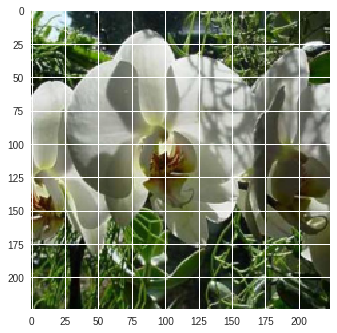

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
        
    if train_on_gpu:    
        image = image.cpu()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image_to_print = imshow(processed_image)


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    '''
    model.eval()
    image = PIL.Image.open(image_path) 
    processed_image = process_image(image)
    processed_image = processed_image.unsqueeze(0)
    
    # TODO: Implement the code to predict the class from an image file
    
    output = F.softmax(model(processed_image),dim=1).cpu().detach().numpy()[0]
    #print(output)
    probs = output[np.argsort(output)[-topk:]][::-1]
    classes = output.argsort()[-topk:][::-1]
    return probs, classes
    
    
probs, classes = predict(image_path, model,5)
print(probs)
print(classes)

[9.8851866e-01 9.4726346e-03 8.7794190e-04 5.6652736e-04 1.4755482e-04]
[69 88 75 15 85]


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes